# 摘要

# 理论模型

大豆属一年生豆科草本植物，俗称黄豆。中国是大豆的原产地，已有 4700 多年种植大豆的历史。20 世纪 30 年代，大豆栽培已遍及世界各国。

![大豆](.\images\大豆.PNG)


## 分类

大豆分为转基因大豆和非转基因大豆。1994 年，美国孟山都公司推出的转基因抗除草剂大豆，成为最早获准推广的转基因大豆品种。由于转基因技术可以使作物产量大幅增长，截至 2008 年,转基因大豆种植面积占全球大豆总面积已扩充至 70%。

## 用途

大豆是一种重要的粮油兼用农产品。

作为食品，大豆是一种优质高含量的植物蛋白资源，它的脂肪、蛋白质、碳水化合物、粗纤维的组成比例非常接近肉类食品。大豆的蛋白质含量为 35-45%，比禾谷类作物高 6-7 倍。联合国粮农组织极力主张发展大豆食品，以解决目前发展中国家蛋白质资源不足的现状。

作为油料作物，大豆是世界上最主要的植物油和蛋白饼粕的提供者。每 1 吨大豆可以制出大约 0.18 吨的豆油和 0.8 吨的豆粕。用大豆制取的豆油，油质好、营养价值高，是一种主要食用植物油。作为大豆榨油的副产品，豆粕主要用于补充喂养家禽、猪、牛等的蛋白质，少部分用在酿造及医药工业上。


## 供给

大豆生产遍及世界，其中北美洲、南美洲和亚洲的种植面积最大。目前美国是全球大豆最大的生产国。美国、巴西、阿根廷是转基因大豆主产国，中国是非转基因大豆主要生产国，大豆作物生产主要集中在黑龙江、吉林、辽宁、内蒙古、河南、山东等省区。

全球大豆以南北半球分为两个收获期，南美（巴西、阿根廷）大豆的收获期是每年的 3-5 月，而地处北半球的美国和中国的大豆收获期是 9-10 月份。因此，每隔 6 个月，大豆都能集中供应。

## 需求

目前中国是国际大豆市场最大的进口国，大豆的进口量和进口价格对国内市场大豆价格影响非常大。

## 替代品

作为食品，大豆的替代品有豌豆、绿豆、芸豆等；作为油籽，大豆的替代品有菜籽、棉籽、葵花籽、花生等。

## 下游产品

它的后续产品为豆油、豆粕。

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

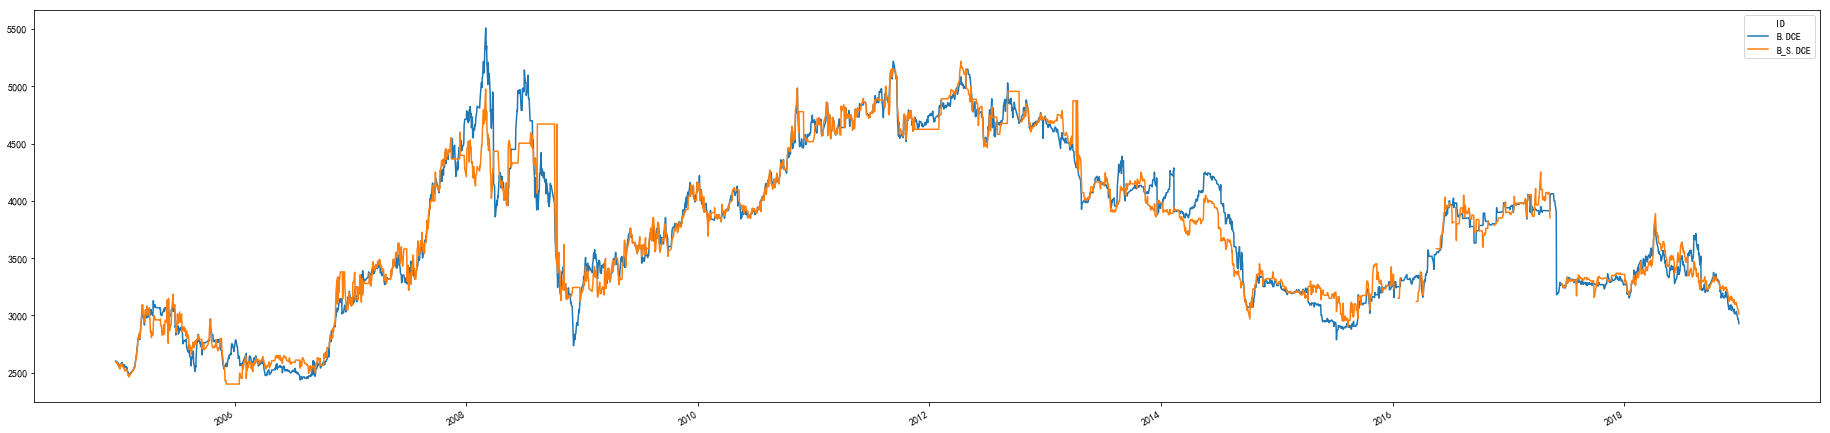

In [2]:
# 参数设置和数据准备
Exchange = "DCE"
MID, SID = "B.DCE", "B_S.DCE"# 主力合约, 次主力合约
StartDT = dt.datetime(2004, 12, 22)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes);

# 附录

## 期货

豆一合约的交割标准是非转基因大豆，豆二合约则包含全球各地的大豆，包括转基因和非转基因的。豆一合约定位于食用大豆，豆二合约定位于榨油用大豆。豆一合约采用的是以现行大豆国家标准为蓝本，以纯粮率为核心定等指标的食用大豆指标体系。豆二合约采用的是以油脂用大豆国家标准为蓝本，以粗脂肪含量为核心定等指标的榨油用大豆指标体系。

黄大豆 1 号期货合约

![黄大豆1号期货合约](.\images\黄大豆1号期货合约.PNG)

黄大豆 2 号期货合约

![黄大豆2号期货合约](.\images\黄大豆2号期货合约.PNG)

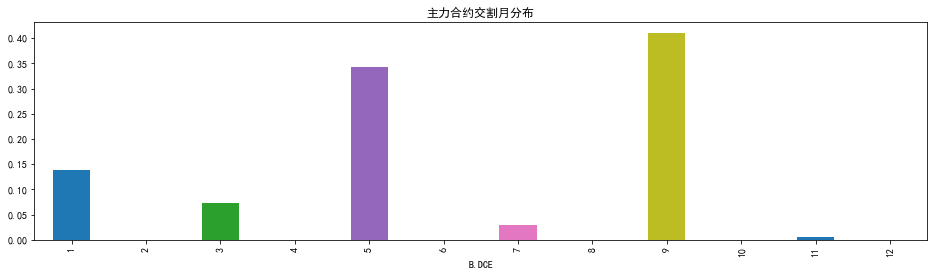

In [3]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

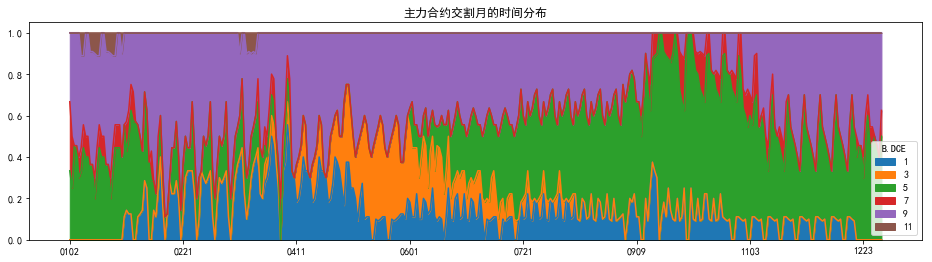

In [4]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);